<a href="https://colab.research.google.com/github/duggi28/Suicide-Sex-Classifier/blob/main/Suicide_Sex_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# math
import numpy as np

# dataframes
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn

# linear regression two ways
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

# for choosing covariates to include in model
from patsy import dmatrices

# model selection
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

from sklearn import datasets

import math

In [2]:
df = pd.read_csv('master.csv')
df[' gdp_for_year ($) ']=df[' gdp_for_year ($) '].str.replace(',','')
df.rename(columns={' gdp_for_year ($) ': 'gdp_for_year'}, inplace=True)
df['gdp_for_year']= df.apply(lambda x: int(x.gdp_for_year) , axis=1)
display(df.head())
# print(df['gdp_for_year'][0] + 1)

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year,gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,2156624900,796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,2156624900,796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,2156624900,796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,2156624900,796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,2156624900,796,Boomers


In [3]:
# ------------------------------------------------------------------------------
# Combined logistic regression model:
# ------------------------------------------------------------------------------
# x includes country, year, population, rates/100k by 6 age groups, total gdp, 
# gdp per capita, ratio of total gdp to per capita gdp, change in total gdp from 
# last year, change in gdp per capita from last year, and change in total gdp to
# per capita gdp form last year
# ------------------------------------------------------------------------------
# y is 1 if males committed majority of suicides, 0 if females
# ------------------------------------------------------------------------------
df_age = df.copy()
df_age = df_age.groupby(['country','year','age']).sum()
df_age['gdp_per_capita ($)'] = df_age['gdp_per_capita ($)']/2
df_age['gdp_for_year'] = df_age['gdp_for_year']/2.0

<ipython-input-3-643f4a60ce99>:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_age = df_age.groupby(['country','year','age']).sum()


In [4]:
display(df_age.head(10))

suicides_no  population  suicides/100k pop  \
country year age                                                       
Albania 1987 15-24 years           35      602600              11.54   
             25-34 years           13      531500               4.84   
             35-54 years           22      586800               7.34   
             5-14 years             0      649200               0.00   
             55-74 years            1      282100               0.73   
             75+ years              2       57400               7.40   
        1988 15-24 years           25      614800               8.04   
             25-34 years           10      542300               3.70   
             35-54 years           18      598600               5.87   
             5-14 years             0      662200               0.00   

                          HDI for year  gdp_for_year  gdp_per_capita ($)  
country year age                                                          
Albania 1987 15-24 years           0.0  2.156625e+09               796.0  
             25-34 years           0.0  2.156625e+09               796.0  
             35-54 years           0.0  2.156625e+09               796.0  
             5-14 years            0.0  2.156625e+09               796.0  
             55-74 years           0.0  2.156625e+09               796.0  
             75+ years             0.0  2.156625e+09               796.0  
        1988 15-24 years           0.0  2.126000e+09               769.0  
             25-34 years           0.0  2.126000e+09               769.0  
             35-54 years           0.0  2.126000e+09               769.0  
             5-14 years            0.0  2.126000e+09               769.0

In [5]:
df_age.reset_index(inplace=True)
for i in range(6):
  df_age[df_age['age'][i]] = np.ones(len(df_age))
  df_age[df_age['age'][i]] = np.ones(len(df_age))
  df_age[df_age['age'][i]] = np.ones(len(df_age))
  df_age[df_age['age'][i]] = np.ones(len(df_age))
  df_age[df_age['age'][i]] = np.ones(len(df_age))
display(df_age.head(10))

,country,year,age,suicides_no,population,suicides/100k pop,HDI for year,gdp_for_year,gdp_per_capita ($),15-24 years,25-34 years,35-54 years,5-14 years,55-74 years,75+ years
0,Albania,1987,15-24 years,35,602600,11.54,0.0,2.156625e+09,796.0,1.0,1.0,1.0,1.0,1.0,1.0
1,Albania,1987,25-34 years,13,531500,4.84,0.0,2.156625e+09,796.0,1.0,1.0,1.0,1.0,1.0,1.0
2,Albania,1987,35-54 years,22,586800,7.34,0.0,2.156625e+09,796.0,1.0,1.0,1.0,1.0,1.0,1.0
3,Albania,1987,5-14 years,0,649200,0.00,0.0,2.156625e+09,796.0,1.0,1.0,1.0,1.0,1.0,1.0
4,Albania,1987,55-74 years,1,282100,0.73,0.0,2.156625e+09,796.0,1.0,1.0,1.0,1.0,1.0,1.0
5,Albania,1987,75+ years,2,57400,7.40,0.0,2.156625e+09,796.0,1.0,1.0,1.0,1.0,1.0,1.0
6,Albania,1988,15-24 years,25,614800,8.04,0.0,2.126000e+09,769.0,1.0,1.0,1.0,1.0,1.0,1.0
7,Albania,1988,25-34 years,10,542300,3.70,0.0,2.126000e+09,769.0,1.0,1.0,1.0,1.0,1.0,1.0
8,Albania,1988,35-54 years,18,598600,5.87,0.0,2.126000e+09,769.0,1.0,1.0,1.0,1.0,1.0,1.0
9,Albania,1988,5-14 years,0,662200,0.00,0.0,2.126000e+09,769.0,1.0,1.0,1.0,1.0,1.0,1.0


In [6]:
for i in range(len(df_age)):
  df_age[df_age['age'][i]][6*math.floor(i/6)] = df_age['suicides/100k pop'][i]


<ipython-input-6-dddbe5bf7ae2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_age[df_age['age'][i]][6*math.floor(i/6)] = df_age['suicides/100k pop'][i]


In [7]:
display(df_age.head(10))

,country,year,age,suicides_no,population,suicides/100k pop,HDI for year,gdp_for_year,gdp_per_capita ($),15-24 years,25-34 years,35-54 years,5-14 years,55-74 years,75+ years
0,Albania,1987,15-24 years,35,602600,11.54,0.0,2.156625e+09,796.0,11.54,4.84,7.34,0.0,0.73,7.40
1,Albania,1987,25-34 years,13,531500,4.84,0.0,2.156625e+09,796.0,1.00,1.00,1.00,1.0,1.00,1.00
2,Albania,1987,35-54 years,22,586800,7.34,0.0,2.156625e+09,796.0,1.00,1.00,1.00,1.0,1.00,1.00
3,Albania,1987,5-14 years,0,649200,0.00,0.0,2.156625e+09,796.0,1.00,1.00,1.00,1.0,1.00,1.00
4,Albania,1987,55-74 years,1,282100,0.73,0.0,2.156625e+09,796.0,1.00,1.00,1.00,1.0,1.00,1.00
5,Albania,1987,75+ years,2,57400,7.40,0.0,2.156625e+09,796.0,1.00,1.00,1.00,1.0,1.00,1.00
6,Albania,1988,15-24 years,25,614800,8.04,0.0,2.126000e+09,769.0,8.04,3.70,5.87,0.0,4.88,9.97
7,Albania,1988,25-34 years,10,542300,3.70,0.0,2.126000e+09,769.0,1.00,1.00,1.00,1.0,1.00,1.00
8,Albania,1988,35-54 years,18,598600,5.87,0.0,2.126000e+09,769.0,1.00,1.00,1.00,1.0,1.00,1.00
9,Albania,1988,5-14 years,0,662200,0.00,0.0,2.126000e+09,769.0,1.00,1.00,1.00,1.0,1.00,1.00


In [8]:
df_age = df_age.iloc[range(0,len(df_age),6)].drop(columns="age")
df_age

,country,year,suicides_no,population,suicides/100k pop,HDI for year,gdp_for_year,gdp_per_capita ($),15-24 years,25-34 years,35-54 years,5-14 years,55-74 years,75+ years
0,Albania,1987,35,602600,11.54,0.000,2.156625e+09,796.0,11.54,4.84,7.34,0.00,0.73,7.40
6,Albania,1988,25,614800,8.04,0.000,2.126000e+09,769.0,8.04,3.70,5.87,0.00,4.88,9.97
12,Albania,1989,17,623400,5.38,0.000,2.335125e+09,833.0,5.38,7.10,7.14,0.00,4.89,8.89
18,Albania,1992,16,556100,5.80,0.000,7.094526e+08,251.0,5.80,4.35,4.11,0.00,3.74,0.00
24,Albania,1993,28,528600,10.91,0.000,1.228071e+09,437.0,10.91,6.58,4.96,0.56,5.42,4.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13884,Uzbekistan,2010,118,2198385,11.22,1.310,3.933277e+10,1533.0,16.24,16.66,16.55,2.74,11.22,6.14
13890,Uzbekistan,2011,95,2304701,8.56,1.322,4.591519e+10,1767.0,20.56,17.17,14.90,3.10,8.56,6.39
13896,Uzbekistan,2012,158,2424547,13.60,1.336,5.182157e+10,1964.0,20.72,17.91,17.16,3.43,13.60,8.20
13902,Uzbekistan,2013,140,2559088,11.44,1.344,5.769045e+10,2150.0,22.69,17.53,18.13,3.84,11.44,8.20


In [9]:
df_age['total_to_per_capita_gdp'] = ((df_age['gdp_for_year']-df_age['gdp_for_year'].mean())/(df_age['gdp_for_year'].std()))/((df_age['gdp_per_capita ($)']-df_age['gdp_per_capita ($)'].mean())/df_age['gdp_per_capita ($)'].std())
df_age.reset_index(inplace=True)

In [10]:
# df_age = df_age.drop(columns=['HDI for year'])
df_age['male']  = np.ones(len(df_age))
df_age['female'] = np.ones(len(df_age))
df_age['majority_sex'] = np.ones(len(df_age)) # 1 if male, 0 if female
df_age

,index,country,year,suicides_no,population,suicides/100k pop,HDI for year,gdp_for_year,gdp_per_capita ($),15-24 years,25-34 years,35-54 years,5-14 years,55-74 years,75+ years,total_to_per_capita_gdp,male,female,majority_sex
0,0,Albania,1987,35,602600,11.54,0.000,2.156625e+09,796.0,11.54,4.84,7.34,0.00,0.73,7.40,0.358421,1.0,1.0,1.0
1,6,Albania,1988,25,614800,8.04,0.000,2.126000e+09,769.0,8.04,3.70,5.87,0.00,4.88,9.97,0.357845,1.0,1.0,1.0
2,12,Albania,1989,17,623400,5.38,0.000,2.335125e+09,833.0,5.38,7.10,7.14,0.00,4.89,8.89,0.359104,1.0,1.0,1.0
3,18,Albania,1992,16,556100,5.80,0.000,7.094526e+08,251.0,5.80,4.35,4.11,0.00,3.74,0.00,0.347796,1.0,1.0,1.0
4,24,Albania,1993,28,528600,10.91,0.000,1.228071e+09,437.0,10.91,6.58,4.96,0.56,5.42,4.13,0.351324,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2314,13884,Uzbekistan,2010,118,2198385,11.22,1.310,3.933277e+10,1533.0,16.24,16.66,16.55,2.74,11.22,6.14,0.344137,1.0,1.0,1.0
2315,13890,Uzbekistan,2011,95,2304701,8.56,1.322,4.591519e+10,1767.0,20.56,17.17,14.90,3.10,8.56,6.39,0.343805,1.0,1.0,1.0
2316,13896,Uzbekistan,2012,158,2424547,13.60,1.336,5.182157e+10,1964.0,20.72,17.91,17.16,3.43,13.60,8.20,0.343199,1.0,1.0,1.0
2317,13902,Uzbekistan,2013,140,2559088,11.44,1.344,5.769045e+10,2150.0,22.69,17.53,18.13,3.84,11.44,8.20,0.342353,1.0,1.0,1.0


In [11]:
df_sex = df.copy()
df_sex = df_sex.groupby(['country','year','sex']).sum()
df_sex['gdp_per_capita ($)'] = df_sex['gdp_per_capita ($)']/6
df_sex['gdp_for_year'] = df_sex['gdp_for_year']/6.0
df_sex.reset_index(inplace=True)
display(df_sex.head(10))

<ipython-input-11-612270a924db>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_sex = df_sex.groupby(['country','year','sex']).sum()


,country,year,sex,suicides_no,population,suicides/100k pop,HDI for year,gdp_for_year,gdp_per_capita ($)
0,Albania,1987,female,25,1316900,11.35,0.0,2.156625e+09,796.0
1,Albania,1987,male,48,1392700,20.50,0.0,2.156625e+09,796.0
2,Albania,1988,female,22,1343600,13.55,0.0,2.126000e+09,769.0
3,Albania,1988,male,41,1420700,18.91,0.0,2.126000e+09,769.0
4,Albania,1989,female,15,1363300,5.52,0.0,2.335125e+09,833.0
5,Albania,1989,male,53,1439800,27.88,0.0,2.335125e+09,833.0
6,Albania,1992,female,14,1423200,5.12,0.0,7.094526e+08,251.0
7,Albania,1992,male,33,1399300,12.88,0.0,7.094526e+08,251.0
8,Albania,1993,female,27,1427400,9.76,0.0,1.228071e+09,437.0
9,Albania,1993,male,46,1379900,22.80,0.0,1.228071e+09,437.0


In [12]:
df_age['female'][0] = df_sex['suicides/100k pop'][0]
for i in range(1, len(df_sex)):
  df_age[df_sex['sex'][i]][math.floor(i/2)] = df_sex['suicides/100k pop'][i]

<ipython-input-12-79049d4a62d0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_age['female'][0] = df_sex['suicides/100k pop'][0]
<ipython-input-12-79049d4a62d0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_age[df_sex['sex'][i]][math.floor(i/2)] = df_sex['suicides/100k pop'][i]
<ipython-input-12-79049d4a62d0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_age[df_sex['sex'][i]][math.floor(i/2)] = df_sex['suicides/100k po

In [13]:
df_age

,index,country,year,suicides_no,population,suicides/100k pop,HDI for year,gdp_for_year,gdp_per_capita ($),15-24 years,25-34 years,35-54 years,5-14 years,55-74 years,75+ years,total_to_per_capita_gdp,male,female,majority_sex
0,0,Albania,1987,35,602600,11.54,0.000,2.156625e+09,796.0,11.54,4.84,7.34,0.00,0.73,7.40,0.358421,20.50,11.35,1.0
1,6,Albania,1988,25,614800,8.04,0.000,2.126000e+09,769.0,8.04,3.70,5.87,0.00,4.88,9.97,0.357845,18.91,13.55,1.0
2,12,Albania,1989,17,623400,5.38,0.000,2.335125e+09,833.0,5.38,7.10,7.14,0.00,4.89,8.89,0.359104,27.88,5.52,1.0
3,18,Albania,1992,16,556100,5.80,0.000,7.094526e+08,251.0,5.80,4.35,4.11,0.00,3.74,0.00,0.347796,12.88,5.12,1.0
4,24,Albania,1993,28,528600,10.91,0.000,1.228071e+09,437.0,10.91,6.58,4.96,0.56,5.42,4.13,0.351324,22.80,9.76,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2314,13884,Uzbekistan,2010,118,2198385,11.22,1.310,3.933277e+10,1533.0,16.24,16.66,16.55,2.74,11.22,6.14,0.344137,52.23,15.58,1.0
2315,13890,Uzbekistan,2011,95,2304701,8.56,1.322,4.591519e+10,1767.0,20.56,17.17,14.90,3.10,8.56,6.39,0.343805,44.94,15.92,1.0
2316,13896,Uzbekistan,2012,158,2424547,13.60,1.336,5.182157e+10,1964.0,20.72,17.91,17.16,3.43,13.60,8.20,0.343199,45.54,17.69,1.0
2317,13902,Uzbekistan,2013,140,2559088,11.44,1.344,5.769045e+10,2150.0,22.69,17.53,18.13,3.84,11.44,8.20,0.342353,47.05,20.09,1.0


In [14]:
df_age['male_suicide_percentage'] = df_age['male']/(df_age['male']+df_age['female'])
df_age['female_suicide_percentage'] = df_age['female']/(df_age['male']+df_age['female'])
df_age['majority_sex'] = df_age.apply(lambda x: int(x.male_suicide_percentage >= 0.5), axis=1)

In [15]:
df_age

,index,country,year,suicides_no,population,suicides/100k pop,HDI for year,gdp_for_year,gdp_per_capita ($),15-24 years,...,35-54 years,5-14 years,55-74 years,75+ years,total_to_per_capita_gdp,male,female,majority_sex,male_suicide_percentage,female_suicide_percentage
0,0,Albania,1987,35,602600,11.54,0.000,2.156625e+09,796.0,11.54,...,7.34,0.00,0.73,7.40,0.358421,20.50,11.35,1,0.643642,0.356358
1,6,Albania,1988,25,614800,8.04,0.000,2.126000e+09,769.0,8.04,...,5.87,0.00,4.88,9.97,0.357845,18.91,13.55,1,0.582563,0.417437
2,12,Albania,1989,17,623400,5.38,0.000,2.335125e+09,833.0,5.38,...,7.14,0.00,4.89,8.89,0.359104,27.88,5.52,1,0.834731,0.165269
3,18,Albania,1992,16,556100,5.80,0.000,7.094526e+08,251.0,5.80,...,4.11,0.00,3.74,0.00,0.347796,12.88,5.12,1,0.715556,0.284444
4,24,Albania,1993,28,528600,10.91,0.000,1.228071e+09,437.0,10.91,...,4.96,0.56,5.42,4.13,0.351324,22.80,9.76,1,0.700246,0.299754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2314,13884,Uzbekistan,2010,118,2198385,11.22,1.310,3.933277e+10,1533.0,16.24,...,16.55,2.74,11.22,6.14,0.344137,52.23,15.58,1,0.770240,0.229760
2315,13890,Uzbekistan,2011,95,2304701,8.56,1.322,4.591519e+10,1767.0,20.56,...,14.90,3.10,8.56,6.39,0.343805,44.94,15.92,1,0.738416,0.261584
2316,13896,Uzbekistan,2012,158,2424547,13.60,1.336,5.182157e+10,1964.0,20.72,...,17.16,3.43,13.60,8.20,0.343199,45.54,17.69,1,0.720228,0.279772
2317,13902,Uzbekistan,2013,140,2559088,11.44,1.344,5.769045e+10,2150.0,22.69,...,18.13,3.84,11.44,8.20,0.342353,47.05,20.09,1,0.700775,0.299225


In [16]:
df_age.drop(columns='HDI for year',inplace=True)

In [17]:
df_age[df_age['majority_sex']==1].count()

index                        2235
country                      2235
year                         2235
suicides_no                  2235
population                   2235
suicides/100k pop            2235
gdp_for_year                 2235
gdp_per_capita ($)           2235
15-24 years                  2235
25-34 years                  2235
35-54 years                  2235
5-14 years                   2235
55-74 years                  2235
75+ years                    2235
total_to_per_capita_gdp      2235
male                         2235
female                       2235
majority_sex                 2235
male_suicide_percentage      2235
female_suicide_percentage    2235
dtype: int64

In [18]:
df_age

,index,country,year,suicides_no,population,suicides/100k pop,gdp_for_year,gdp_per_capita ($),15-24 years,25-34 years,35-54 years,5-14 years,55-74 years,75+ years,total_to_per_capita_gdp,male,female,majority_sex,male_suicide_percentage,female_suicide_percentage
0,0,Albania,1987,35,602600,11.54,2.156625e+09,796.0,11.54,4.84,7.34,0.00,0.73,7.40,0.358421,20.50,11.35,1,0.643642,0.356358
1,6,Albania,1988,25,614800,8.04,2.126000e+09,769.0,8.04,3.70,5.87,0.00,4.88,9.97,0.357845,18.91,13.55,1,0.582563,0.417437
2,12,Albania,1989,17,623400,5.38,2.335125e+09,833.0,5.38,7.10,7.14,0.00,4.89,8.89,0.359104,27.88,5.52,1,0.834731,0.165269
3,18,Albania,1992,16,556100,5.80,7.094526e+08,251.0,5.80,4.35,4.11,0.00,3.74,0.00,0.347796,12.88,5.12,1,0.715556,0.284444
4,24,Albania,1993,28,528600,10.91,1.228071e+09,437.0,10.91,6.58,4.96,0.56,5.42,4.13,0.351324,22.80,9.76,1,0.700246,0.299754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2314,13884,Uzbekistan,2010,118,2198385,11.22,3.933277e+10,1533.0,16.24,16.66,16.55,2.74,11.22,6.14,0.344137,52.23,15.58,1,0.770240,0.229760
2315,13890,Uzbekistan,2011,95,2304701,8.56,4.591519e+10,1767.0,20.56,17.17,14.90,3.10,8.56,6.39,0.343805,44.94,15.92,1,0.738416,0.261584
2316,13896,Uzbekistan,2012,158,2424547,13.60,5.182157e+10,1964.0,20.72,17.91,17.16,3.43,13.60,8.20,0.343199,45.54,17.69,1,0.720228,0.279772
2317,13902,Uzbekistan,2013,140,2559088,11.44,5.769045e+10,2150.0,22.69,17.53,18.13,3.84,11.44,8.20,0.342353,47.05,20.09,1,0.700775,0.299225


In [19]:
df_age.sort_values(['country', 'year'], inplace=True)
df_age

,index,country,year,suicides_no,population,suicides/100k pop,gdp_for_year,gdp_per_capita ($),15-24 years,25-34 years,35-54 years,5-14 years,55-74 years,75+ years,total_to_per_capita_gdp,male,female,majority_sex,male_suicide_percentage,female_suicide_percentage
0,0,Albania,1987,35,602600,11.54,2.156625e+09,796.0,11.54,4.84,7.34,0.00,0.73,7.40,0.358421,20.50,11.35,1,0.643642,0.356358
1,6,Albania,1988,25,614800,8.04,2.126000e+09,769.0,8.04,3.70,5.87,0.00,4.88,9.97,0.357845,18.91,13.55,1,0.582563,0.417437
2,12,Albania,1989,17,623400,5.38,2.335125e+09,833.0,5.38,7.10,7.14,0.00,4.89,8.89,0.359104,27.88,5.52,1,0.834731,0.165269
3,18,Albania,1992,16,556100,5.80,7.094526e+08,251.0,5.80,4.35,4.11,0.00,3.74,0.00,0.347796,12.88,5.12,1,0.715556,0.284444
4,24,Albania,1993,28,528600,10.91,1.228071e+09,437.0,10.91,6.58,4.96,0.56,5.42,4.13,0.351324,22.80,9.76,1,0.700246,0.299754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2314,13884,Uzbekistan,2010,118,2198385,11.22,3.933277e+10,1533.0,16.24,16.66,16.55,2.74,11.22,6.14,0.344137,52.23,15.58,1,0.770240,0.229760
2315,13890,Uzbekistan,2011,95,2304701,8.56,4.591519e+10,1767.0,20.56,17.17,14.90,3.10,8.56,6.39,0.343805,44.94,15.92,1,0.738416,0.261584
2316,13896,Uzbekistan,2012,158,2424547,13.60,5.182157e+10,1964.0,20.72,17.91,17.16,3.43,13.60,8.20,0.343199,45.54,17.69,1,0.720228,0.279772
2317,13902,Uzbekistan,2013,140,2559088,11.44,5.769045e+10,2150.0,22.69,17.53,18.13,3.84,11.44,8.20,0.342353,47.05,20.09,1,0.700775,0.299225


In [20]:
df_age_2 = df_age.copy()
df_age_2['change_in_total_gdp'] = np.ones(len(df_age_2))
df_age_2['change_in_gdp_per_capita'] = np.ones(len(df_age_2))
df_age_2['change_in_total_to_per_capita_gdp'] = np.ones(len(df_age_2))

df_age_2['change_in_total_gdp'][0] = (df_age_2['gdp_for_year'][1] - df_age_2['gdp_for_year'][0])/(df_age_2['gdp_for_year'][0])
df_age_2['change_in_gdp_per_capita'][0] = (df_age_2['gdp_per_capita ($)'][1] - df_age_2['gdp_per_capita ($)'][0])/(df_age_2['gdp_per_capita ($)'][0])
df_age_2['change_in_total_to_per_capita_gdp'][0] = (df_age_2['total_to_per_capita_gdp'][1] - df_age_2['total_to_per_capita_gdp'][0])/(df_age_2['total_to_per_capita_gdp'][0])
for i in range(1, len(df_age_2)):
  if df_age_2['year'][i-1] > df_age_2['year'][i]:
    df_age_2['change_in_total_gdp'][i] = (df_age_2['gdp_for_year'][i+1] - df_age_2['gdp_for_year'][i])/(df_age_2['gdp_for_year'][i])
    df_age_2['change_in_gdp_per_capita'][i] = (df_age_2['gdp_per_capita ($)'][i+1] - df_age_2['gdp_per_capita ($)'][i])/(df_age_2['gdp_per_capita ($)'][i])
    df_age_2['change_in_total_to_per_capita_gdp'][i] =(df_age_2['total_to_per_capita_gdp'][i+1] - df_age_2['total_to_per_capita_gdp'][i])/(df_age_2['total_to_per_capita_gdp'][i])
  else:
    df_age_2['change_in_total_gdp'][i] = (df_age_2['gdp_for_year'][i] - df_age_2['gdp_for_year'][i-1])/(df_age_2['gdp_for_year'][i-1])
    df_age_2['change_in_gdp_per_capita'][i] = (df_age_2['gdp_per_capita ($)'][i] - df_age_2['gdp_per_capita ($)'][i-1])/(df_age_2['gdp_per_capita ($)'][i-1])
    df_age_2['change_in_total_to_per_capita_gdp'][i] =(df_age_2['total_to_per_capita_gdp'][i] - df_age_2['total_to_per_capita_gdp'][i-1])/(df_age_2['total_to_per_capita_gdp'][i-1])

<ipython-input-20-0fa526a16947>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_age_2['change_in_total_gdp'][0] = (df_age_2['gdp_for_year'][1] - df_age_2['gdp_for_year'][0])/(df_age_2['gdp_for_year'][0])
<ipython-input-20-0fa526a16947>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_age_2['change_in_gdp_per_capita'][0] = (df_age_2['gdp_per_capita ($)'][1] - df_age_2['gdp_per_capita ($)'][0])/(df_age_2['gdp_per_capita ($)'][0])
<ipython-input-20-0fa526a16947>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.

In [21]:
df_age_2

,index,country,year,suicides_no,population,suicides/100k pop,gdp_for_year,gdp_per_capita ($),15-24 years,25-34 years,...,75+ years,total_to_per_capita_gdp,male,female,majority_sex,male_suicide_percentage,female_suicide_percentage,change_in_total_gdp,change_in_gdp_per_capita,change_in_total_to_per_capita_gdp
0,0,Albania,1987,35,602600,11.54,2.156625e+09,796.0,11.54,4.84,...,7.40,0.358421,20.50,11.35,1,0.643642,0.356358,-0.014200,-0.033920,-0.001608
1,6,Albania,1988,25,614800,8.04,2.126000e+09,769.0,8.04,3.70,...,9.97,0.357845,18.91,13.55,1,0.582563,0.417437,-0.014200,-0.033920,-0.001608
2,12,Albania,1989,17,623400,5.38,2.335125e+09,833.0,5.38,7.10,...,8.89,0.359104,27.88,5.52,1,0.834731,0.165269,0.098365,0.083225,0.003518
3,18,Albania,1992,16,556100,5.80,7.094526e+08,251.0,5.80,4.35,...,0.00,0.347796,12.88,5.12,1,0.715556,0.284444,-0.696182,-0.698679,-0.031488
4,24,Albania,1993,28,528600,10.91,1.228071e+09,437.0,10.91,6.58,...,4.13,0.351324,22.80,9.76,1,0.700246,0.299754,0.731012,0.741036,0.010142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2314,13884,Uzbekistan,2010,118,2198385,11.22,3.933277e+10,1533.0,16.24,16.66,...,6.14,0.344137,52.23,15.58,1,0.770240,0.229760,0.167518,0.150901,-0.000780
2315,13890,Uzbekistan,2011,95,2304701,8.56,4.591519e+10,1767.0,20.56,17.17,...,6.39,0.343805,44.94,15.92,1,0.738416,0.261584,0.167352,0.152642,-0.000966
2316,13896,Uzbekistan,2012,158,2424547,13.60,5.182157e+10,1964.0,20.72,17.91,...,8.20,0.343199,45.54,17.69,1,0.720228,0.279772,0.128637,0.111488,-0.001763
2317,13902,Uzbekistan,2013,140,2559088,11.44,5.769045e+10,2150.0,22.69,17.53,...,8.20,0.342353,47.05,20.09,1,0.700775,0.299225,0.113252,0.094705,-0.002463


In [22]:
y = df_age_2['majority_sex']

In [23]:
df_age_3 = df_age_2['country'].unique()
df_age_3 = pd.DataFrame(df_age_3)
df_age_3.rename(columns={0:'country'},inplace=True)
df_age_3['key'] = np.arange(1,len(df_age_3)+1,1)
df_age_3.set_index('country',inplace=True)
df_age_3

,key
country,
Albania,1
Antigua and Barbuda,2
Argentina,3
Armenia,4
Aruba,5
...,...
United Arab Emirates,97
United Kingdom,98
United States,99


In [24]:
dict_age_3 = df_age_3.to_dict('index')
type(dict_age_3['Albania']['key'])

int

In [25]:
y = df_age_2['majority_sex']
features = df_age_2.drop(columns=['majority_sex','suicides_no','suicides/100k pop','male','female','male_suicide_percentage','female_suicide_percentage']).columns[:] 
df_age_4 = df_age_2.copy()
for i in range(len(df_age_2)):
  df_age_4['country'][i] = float(dict_age_3[df_age_2['country'][i]]['key'])
# df['gdp_for_year']= df.apply(lambda x: int(x.gdp_for_year) , axis=1)
X = sm.add_constant(df_age_4[features])
X.head()

<ipython-input-25-27f40d4e23e0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_age_4['country'][i] = float(dict_age_3[df_age_2['country'][i]]['key'])


,const,index,country,year,population,gdp_for_year,gdp_per_capita ($),15-24 years,25-34 years,35-54 years,5-14 years,55-74 years,75+ years,total_to_per_capita_gdp,change_in_total_gdp,change_in_gdp_per_capita,change_in_total_to_per_capita_gdp
0,1.0,0,1.0,1987,602600,2.156625e+09,796.0,11.54,4.84,7.34,0.00,0.73,7.40,0.358421,-0.014200,-0.033920,-0.001608
1,1.0,6,1.0,1988,614800,2.126000e+09,769.0,8.04,3.70,5.87,0.00,4.88,9.97,0.357845,-0.014200,-0.033920,-0.001608
2,1.0,12,1.0,1989,623400,2.335125e+09,833.0,5.38,7.10,7.14,0.00,4.89,8.89,0.359104,0.098365,0.083225,0.003518
3,1.0,18,1.0,1992,556100,7.094526e+08,251.0,5.80,4.35,4.11,0.00,3.74,0.00,0.347796,-0.696182,-0.698679,-0.031488
4,1.0,24,1.0,1993,528600,1.228071e+09,437.0,10.91,6.58,4.96,0.56,5.42,4.13,0.351324,0.731012,0.741036,0.010142


In [26]:
X = X.astype({'country':int})

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [28]:
model = sm.Logit(y_train,X_train).fit()
print(model.summary())


Optimization terminated successfully.
         Current function value: 0.081257
         Iterations 14
                           Logit Regression Results                           
Dep. Variable:           majority_sex   No. Observations:                 1553
Model:                          Logit   Df Residuals:                     1536
Method:                           MLE   Df Model:                           16
Date:                Sun, 21 May 2023   Pseudo R-squ.:                  0.4289
Time:                        22:37:08   Log-Likelihood:                -126.19
converged:                       True   LL-Null:                       -220.98
Covariance Type:            nonrobust   LLR p-value:                 1.003e-31
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                               -15.3975     42.216     -

In [29]:
significant_covariates = list(model.pvalues[model.pvalues<=0.05].index)
significant_covariates

['index', 'country', 'population', '15-24 years']

In [30]:
model2 = sm.Logit(y_test,X_test).fit()
print(model2.summary())

Optimization terminated successfully.
         Current function value: 0.088881
         Iterations 14
                           Logit Regression Results                           
Dep. Variable:           majority_sex   No. Observations:                  766
Model:                          Logit   Df Residuals:                      749
Method:                           MLE   Df Model:                           16
Date:                Sun, 21 May 2023   Pseudo R-squ.:                  0.5107
Time:                        22:37:08   Log-Likelihood:                -68.082
converged:                       True   LL-Null:                       -139.14
Covariance Type:            nonrobust   LLR p-value:                 2.780e-22
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                61.1763     62.004      

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


In [31]:
significant_covariates_test = list(model2.pvalues[model2.pvalues<=0.05].index)
significant_covariates_test

['15-24 years', 'change_in_total_to_per_capita_gdp']

# Final Model with Signficant Features Only ($\alpha = 0.05$) 

In [32]:
sig_features = list(set(significant_covariates).union(set(significant_covariates_test)))
sig_features

['country',
 '15-24 years',
 'change_in_total_to_per_capita_gdp',
 'index',
 'population']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X[sig_features], y, test_size=0.2, random_state=1)

In [36]:
model3 = sm.Logit(y_train,X_train).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.107350
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:           majority_sex   No. Observations:                 1553
Model:                          Logit   Df Residuals:                     1536
Method:                           MLE   Df Model:                           16
Date:                Sun, 21 May 2023   Pseudo R-squ.:                  0.4289
Time:                        22:37:49   Log-Likelihood:                -126.19
converged:                       True   LL-Null:                       -220.98
Covariance Type:            nonrobust   LLR p-value:                 1.003e-31
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                               -15.3975     42.216     -

In [37]:
# Calculate mean squared error for both testing and training
yhat_train = model3.predict(X_train)
print('training error =', np.mean(yhat_train - y_train)**2) 
yhat_test = model3.predict(X_test)
print('testing error =', np.mean(yhat_test - y_test)**2)

training error = 3.2658125752689056e-05
testing error = 0.0002605501390057438


Text(0.5, 1.0, 'Receiver Operating Curve (ROC)')

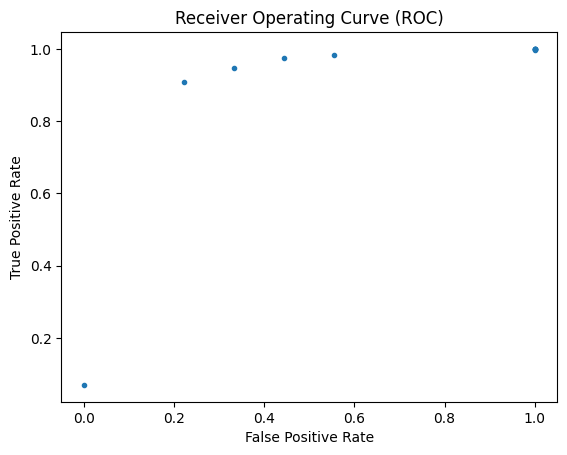

In [38]:
thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
positives = len(X_test[y_test==1])
negatives = len(X_test[y_test==0])
class_rates = {}
for threshold in thresholds:
  predictions = model3.predict(X_test)
  predictions = predictions.map(lambda x: 1 if x>= threshold else 0)
  true_pos = (y_test==1) & (predictions==y_test)
  false_pos = (y_test==0) & (predictions!=y_test)
  tp = len(X_test[true_pos])
  fp = len(X_test[false_pos])
  class_rates[threshold] = {'FPR':(fp/negatives)*1.0,'TPR': (tp/positives)*1.0}
class_rates = pd.DataFrame(list(class_rates.values()))
class_rates['threshold'] = thresholds
# display(class_rates)
plt.plot(class_rates['FPR'],class_rates['TPR'],'.',)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Curve (ROC)')

In [39]:
from sklearn.metrics import auc
area = auc(class_rates['FPR'],class_rates['TPR'])
print("area =", area)

area = 0.8671550671550671


# The area under the ROC curve is $0.867$, so the model performs $100 \times (0.867 - 0.500) = 36.7\% $ better than a random classifier.